In [ ]:
'''
【项目08】  电商打折套路解析

作业要求
1、从现有数据中，分析出“各个品牌都有多少商品参加了双十一活动？”
要求：
① 计算得到：商品总数、品牌总数
② 双十一当天在售的商品占比情况（思考：是不是只有双十一当天在售的商品是“参与双十一活动的商品？”）
③ 未参与双十一当天活动的商品，在双十一之后的去向如何？
④ 真正参与双十一活动的品牌有哪些？其各个品牌参与双十一活动的商品数量分布是怎样的？
   * 用bokeh绘制柱状图表示
提示：
① 数据的“id”字段为商品的实际唯一标识，“title”字段则为商品在网页上显示的名称
   * 仔细看数据可以发现，同一个id的title不一定一样（双十一前后）
② 数据的“店名”字段为品牌的唯一标识
③ 按照商品销售节奏分类，我们可以将商品分为7类
   A. 11.11前后及当天都在售 → 一直在售
   B. 11.11之后停止销售 → 双十一后停止销售
   C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   D. 11.11开始销售且当天停止 → 仅双十一当天有售
   E. 11.5 - 11.10 → 双十一前停止销售
   F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   G. 11.12开始销售 → 双十一后上架
④ 未参与双十一当天活动的商品，可能有四种情况：
   con1 → 暂时下架（F）
   con2 → 重新上架（E中部分数据，数据中同一个id可能有不同title，“换个马甲重新上架”），字符串查找特定字符 dataframe.str.contains('预售')
   con3 → 预售（E中部分数据，预售商品的title中包含“预售”二字）
   con4 → 彻底下架（E中部分数据），可忽略
⑤ 真正参加活动的商品 = 双十一当天在售的商品 + 预售商品 （可以尝试结果去重）
   通过上述几个指标计算，研究出哪些是真正参与双十一活动的品牌，且其商品数量是多少
   
2、哪些商品真的在打折呢？
要求：
① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度
提示：
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

3、商家营销套路挖掘？
要求：
① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
提示：
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路

'''

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

Loading BokehJS ...

In [2]:
'''
（1）导入数据
'''
import os
os.chdir('C:/Users/Administrator/Desktop/')
df = pd.read_excel('data1.xlsx')

df.fillna(0, inplace = True)
df.index = df['update_time']
df['date'] = df.index.day
#加载数据，提取日期

双十一当天参与活动的商品为2336个， 占比66.70%
未参与双十一当天活动的商品中：242个为暂时下架，110个重新上架商品，453个为预售商品


finish


sale_on_11    20809
presell        2781
sum           23590
dtype: int64

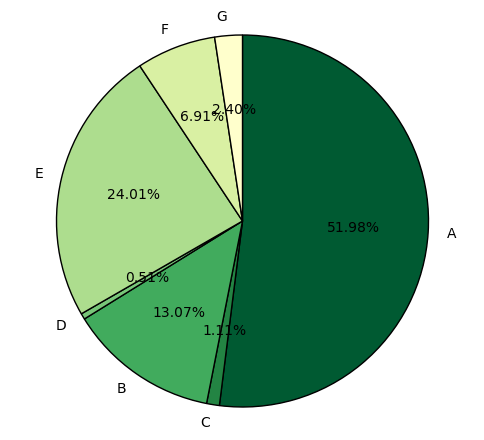

In [3]:
'''
（2）双十一当天在售的商品占比情况
'''
data1 = df[['id', 'title', '店名', 'date']]
d1 = data1[['id', 'date']].groupby(by = 'id').agg(['min', 'max'])['date'] #每个商品销售的第一天和最后一天的日期；
#统计不同商品的销售开始、结束日期

id_11 = data1[data1['date'] == 11]['id']
d2 = pd.DataFrame({'id':id_11, '双十一当天是否售卖':True})
#筛选双十一当天售卖的商品id

id_date = pd.merge(d1, d2, left_index = True, right_on = 'id', how = 'left')
id_date.fillna(False, inplace = True)
m = len(d1)
m_11 = len(id_11)
m_pre = m_11 / m
print('双十一当天参与活动的商品为%i个， 占比%.2f%%' % (m_11, m_pre*100))

'''
（3）商品销售节奏分类
'''
id_date['type'] = '待分类'
id_date['type'][(id_date['min'] < 11 ) & (id_date['max'] > 11)] = 'A'
id_date['type'][(id_date['min'] < 11 ) & (id_date['max'] == 11)] = 'B'
id_date['type'][(id_date['min'] == 11 ) & (id_date['max'] > 11)] = 'C'
id_date['type'][(id_date['min'] == 11 ) & (id_date['max'] == 11)] = 'D'
id_date['type'][id_date['双十一当天是否售卖'] == False] = 'F'
id_date['type'][id_date['max'] < 11] = 'E'
id_date['type'][id_date['min'] > 11] = 'G'
#销售节奏分类

result1 = id_date['type'].value_counts()
result1 = result1.loc[['A', 'C','B', 'D', 'E', 'F', 'G']]
#计算不同类别的商品数量

from bokeh.palettes import brewer
colori = brewer['YlGn'][7]

plt.axis('equal')
plt.pie(result1, labels = result1.index, autopct = '%.2f%%', colors = colori,
        startangle = 90, radius = 1.5, counterclock = False)

'''
（4）未参与双十一当天活动的商品，去向如何
'''
id_not11 = id_date[id_date['双十一当天是否售卖'] == False]
df_not11 = id_not11[['id', 'type']]
data_not11 = pd.merge(df_not11, df, on = 'id', how = 'left')
#找到双十一当天未参与活动的商品对应的原始数据

id_con1 = id_date['id'][id_date['type'] == 'F'].values
#筛选出con1，双十一暂时下架的商品
data_con2 = data_not11[['id','title','date']].groupby(by = ['id','title']).count()
#做个分类，区分，分组，计数

title_count = data_con2.reset_index()['id'].value_counts() #同一个id可能有两个名称
#data_not11[data_not11['id'] == 'A536510937963'] 这里id有多个名称
id_con2 = title_count[title_count > 1].index
#筛选出con2,id不止一个的名称

data_con3 = data_not11[data_not11['title'].str.contains('预售')]
id_con3 = data_con3['id'].value_counts().index
#筛选出con3，预售的
print('未参与双十一当天活动的商品中：%i个为暂时下架，%i个重新上架商品，%i个为预售商品'%(len(id_con1), len(id_con2), len(id_con3)))

'''
（5）真正参与双十一活动的商品及品牌情况
真正参与双十一活动的商品 = 双十一当天在售的商品 + 预售商品 （可尝试结果去重）

'''
data_11sale = id_11 #双十一当天在售的
id_11sale_final = np.hstack((data_11sale, id_con3)) #垂直竖向堆叠把他俩加起来，真正参加活动的商品
result2_i = pd.DataFrame({'id':id_11sale_final}) #把它变成dataframe
#真正参与双十一活动的商品,只得到它的id，还要得到它的品牌---->>>
x1 = pd.DataFrame({'id':id_11})
x1_df = pd.merge(x1, df, on = 'id', how = 'left')  #把源数据找到
brand_11sale = x1_df.groupby('店名')['id'].count()
#不同品牌当天参与双十一活动的商品数量
x2 = pd.DataFrame({'id':id_con3})
x2_df = pd.merge(x2, df, on = 'id', how = 'left')
brand_ys = x2_df.groupby('店名')['id'].count()
#不同品牌的预售商品数量

result2_data = pd.DataFrame({'当天参与活动的商品数量': brand_11sale, '预售商品数量':brand_ys})
result2_data['总量'] = result2_data['当天参与活动的商品数量'] + result2_data['预售商品数量']
result2_data.sort_values(by = '总量', inplace = True, ascending = False)
#计算结果

from bokeh.models import HoverTool
from bokeh.core.properties import value

lst_brand = result2_data.index.tolist()
lst_type = result2_data.columns.tolist()[: 2]
colors = ['red', 'green']
#基本参数

result2_data.index.name = 'brand'
result2_data.columns = ['sale_on_11', 'presell', 'sum']
source = ColumnDataSource(result2_data)

hover = HoverTool(tooltips = [("品牌", "@brand"),
                              ("双十一当天参与活动的商品数量", "@sale_on_11"),
                              ("预售商品数量", "@presell"),
                              ("真正参与双十一活动的商品总数", "@sum")])

p = figure(x_range = lst_brand, plot_width = 900, plot_height = 350,
           title = '各个品牌参与双十一活动的情况',
           tools = [hover, 'xwheel_zoom, pan, crosshair'])
p.vbar(top = 'sum', x = 'brand', source = source,
       width = 0.9,
       #color = colors,
       alpha = 0.7)
       #legend = [value(x) for x in 1st_type]
show(p)

print('finish')

result2_data.sum()

In [6]:
'''
2、哪些商品真的在打折呢？

① 针对每个商品，评估其打折的情况
② 针对在打折的商品，其折扣率是多少
   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量
③ 按照品牌分析，不同品牌的打折力度
   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度

----->>>
① 打折情况评估方法：
   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象
   不打折：商品价格无变化
② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段
   data[['id','price','date']].groupby(['id','price']).min()
   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折
③ 折扣率 = 双十一当天价格 / 双十一之前价格
④ 作图过程中，清除掉折扣率大于95%的数据

'''

"\n2、哪些商品真的在打折呢？\n\n① 针对每个商品，评估其打折的情况\n② 针对在打折的商品，其折扣率是多少\n   * 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量\n③ 按照品牌分析，不同品牌的打折力度\n   * 用bokeh绘制浮动散点图，y坐标为品牌类型，x坐标为折扣力度\n\n----->>>\n① 打折情况评估方法：\n   真打折：商品的价格在10天内有波动、双11价格为10天内最低价、不存在涨价现象\n   不打折：商品价格无变化\n② 针对每个商品做price字段的value值统计，查看价格是否有波动，可以先用pd.cut将date分为不同周期：'双十一前','双十一当天','双十一后'，得到period字段\n   data[['id','price','date']].groupby(['id','price']).min()\n   针对统计出来的结果，如果按照id和price分组仍只有一个唯一值，则说明价格未变，没打折；否则为打折\n③ 折扣率 = 双十一当天价格 / 双十一之前价格\n④ 作图过程中，清除掉折扣率大于95%的数据\n\n"

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource

from bokeh.models import HoverTool
from bokeh.core.properties import value

'''
（1）导入数据
'''
import os
os.chdir('C:/Users/Administrator/Desktop/')
df = pd.read_excel('data1.xlsx')


df.fillna(0, inplace = True)
df.index = df['update_time']
df['date'] = df.index.day
#加载数据，提取日期

data2 = df[['id', 'title', '店名', 'date', 'price']]
data2['period'] = pd.cut(data2['date'], [4,10,11,14], labels = ['双十一前', '双十一当天', '双十一后'])
#筛选数据
'''
（2）针对每个商品，评估其打折的情况
'''
price = data2[['id', 'price', 'period']].groupby(['id', 'price']).min()
price.reset_index(inplace = True)
#查看数据是否有波动

id_count = price['id'].value_counts()
id_type1 = id_count[id_count == 1].index
id_type2 = id_count[id_count != 1].index
#筛选出“不打折”与“打折”商品数量

'''
（3）针对在打折的商品，其折扣率是多少，并制作图表
'''
result3_data1 = data2[['id', 'price', 'period', '店名']].groupby(['id', 'price']).min()
result3_data1.reset_index(inplace = True)
#筛选数据

result3_before11 = result3_data1[result3_data1['period'] == '双十一前']
result3_at11 = result3_data1[result3_data1['period'] == '双十一当天']
result3_data2 = pd.merge(result3_before11, result3_at11, on = 'id')
#合并数据

result3_data2['zkl'] = result3_data2['price_y'] / result3_data2['price_x']
#计算折扣率

bokeh_data = result3_data2[['id', 'zkl']].dropna()
bokeh_data['zkl_range'] = pd.cut(bokeh_data['zkl'], bins = np.linspace(0, 1, 21))
bokeh_data2 = bokeh_data.groupby('zkl_range').count().iloc[:-1]
bokeh_data2['zkl_pre'] = bokeh_data2['zkl'] / bokeh_data2['zkl'].sum()
#计算折扣区间占比

source1 = ColumnDataSource(bokeh_data2)
lst_zkl = bokeh_data2.index.tolist()
hover = HoverTool(tooltips = [("折扣率", "@zkl")])

p = figure(x_range= lst_zkl, plot_width=900 ,plot_height=350, title = '商品折扣率统计',
           tools = [hover, 'reset, xwheel_zoom, pan, crosshair'])
p.line(x = 'zkl_range', y = 'zkl_pre', source = source1, line_color = 'black',line_dash = (10,4))
p.circle(x = 'zkl_range', y = 'zkl_pre', source = source1, size = 8, color = 'red', alpha = 0.8)
show(p)

'''
（4）按照品牌分析，不同品牌的打折力度
'''
from bokeh.transform import jitter
brands = result3_data2['店名_x'].dropna().unique().tolist()
bokeh_data3 = result3_data2[['id', 'zkl', '店名_x']].dropna()
bokeh_data3 = bokeh_data3[bokeh_data3['zkl'] < 0.96]
source2 = ColumnDataSource(bokeh_data3)

p2 = figure(y_range = brands, plot_width = 900, plot_height = 600, title = '不同品牌的折扣情况',
            tools = [hover, 'box_select, reset, xwheel_zoom, pan, crosshair'])
p2.circle(x = 'zkl', 
          y = jitter('店名_x', width = 0.7, range = p2.y_range),
            source = source2, alpha = 0.3)
show(p2)

print('finish')

finish


In [10]:
'''
3、商家营销套路挖掘？

① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路
   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数
---->>>
① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据
② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路
'''

'\n3、商家营销套路挖掘？\n\n① 解析出不同品牌的参与打折商品比例及折扣力度，并做散点图，总结打折套路\n   * 用bokeh绘制散点图，x轴为参与打折商品比例，y轴为折扣力度，点的大小代表该品牌参加双11活动的商品总数\n---->>>\n① 折扣力度为该品牌所有打折商品的折扣均值，这里去掉品牌中不打折的数据\n② 绘制散点图后，可以将x、y轴绘制均值辅助线，将绘图空间分为四个象限，基于该象限来总结套路\n'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource

from bokeh.models import HoverTool

'''
（1）数据计算
'''



data_zk = result3_data2[result3_data2['zkl'] < 0.95]
result4_zkld = data_zk.groupby('店名_y')['zkl'].mean()
#筛选出不同品牌的折扣情况

n_dz = data_zk['店名_y'].value_counts()
n_zs = result3_data2['店名_y'].value_counts()
result4_dzspb1 = pd.DataFrame({'打折商品数': n_dz, '商品总数': n_zs})
result4_dzspb1['参与打折商品比例'] = result4_dzspb1['打折商品数'] / result4_dzspb1['商品总数']
result4_dzspb1.dropna(inplace = True)

result4_sum = result2_data.copy()

result4_data = pd.merge(pd.DataFrame(result4_zkld), result4_dzspb1, left_index = True, right_index = True, how = 'inner')
result4_data = pd.merge(result4_data,result4_sum,left_index = True, right_index = True, how = 'inner')


'''
（2）bokeh作图
'''

from bokeh.models.annotations import Span            # 导入Span模块
from bokeh.models.annotations import Label           # 导入Label模块
from bokeh.models.annotations import BoxAnnotation   # 导入BoxAnnotation模块


bokeh_data = result4_data[['zkl','sum','参与打折商品比例']]
bokeh_data.columns = ['zkl','amount','pre']
bokeh_data['size'] = bokeh_data['amount'] * 0.03
source = ColumnDataSource(bokeh_data)
# 创建ColumnDataSource数据

x_mean = bokeh_data['pre'].mean()
y_mean = bokeh_data['zkl'].mean()

hover = HoverTool(tooltips=[("品牌", "@index"),
                            ("折扣率", "@zkl"),
                            ("商品总数", "@amount"),
                            ("参与打折商品比例", "@pre"),
                           ])  # 设置标签显示内容

p = figure(plot_width=600, plot_height=600,
                title="各个品牌打折套路解析" , 
                tools=[hover,'box_select,reset,wheel_zoom,pan,crosshair']) 
# 构建绘图空间

p.circle_x(x = 'pre',y = 'zkl',source = source,size = 'size',
           fill_color = 'red',line_color = 'black',fill_alpha = 0.6,line_dash = [8,3])
p.ygrid.grid_line_dash = [6, 4]
p.xgrid.grid_line_dash = [6, 4]
# 散点图

x = Span(location=x_mean, dimension='height', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
y = Span(location=y_mean, dimension='width', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
p.add_layout(x)
p.add_layout(y)
# 绘制辅助线

bg1 = BoxAnnotation(bottom=y_mean, right=x_mean,fill_alpha=0.1, fill_color='olive')
label1 = Label(x=0.1, y=0.55,text="少量大打折",text_font_size="10pt" )
p.add_layout(bg1)
p.add_layout(label1)
# 绘制第一象限

bg2 = BoxAnnotation(bottom=y_mean, left=x_mean,fill_alpha=0.1, fill_color='firebrick')
label2 = Label(x=0.7, y=0.55,text="大量大打折",text_font_size="10pt" )
p.add_layout(bg2)
p.add_layout(label2)
# 绘制第二象限

bg3 = BoxAnnotation(top=y_mean, right=x_mean,fill_alpha=0.1, fill_color='firebrick')
label3 = Label(x=0.1, y=0.80,text="少量少打折",text_font_size="10pt" )
p.add_layout(bg3)
p.add_layout(label3)
# 绘制第三象限

bg4 = BoxAnnotation(top=y_mean, left=x_mean,fill_alpha=0.1, fill_color='olive')
label4 = Label(x=0.7, y=0.80,text="少量大打折",text_font_size="10pt" )
p.add_layout(bg4)
p.add_layout(label4)
# 绘制第四象限

show(p)